In [14]:
# Looker Link
# https://lookerstudio.google.com/reporting/eeec3f5f-a2fc-4028-b17b-2f3ec80da1a0

In [1]:
import seaborn as sns
from datetime import datetime
import pandas as pd
from scipy.stats import anderson, shapiro, pearsonr, mannwhitneyu
from sklearn.utils import shuffle
from scipy import stats

import numpy as np
import sqlite3
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

You will learn about how to conduct experiments, what are Type 1 and Type 2 errors, and what are significance levels. In the Data Science from Scratch you will learn about statistical hypothesis testing, review p-Values, confidence intervals, and Bayesian inference.

# LOAD THE DATA

In [2]:
table_df = "/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/SPRINT_2/DATA/database.sqlite"
conn = sqlite3.connect(table_df)

podcast = pd.read_sql("""
                    SELECT slug, title, podcast_id
                    FROM podcasts
                    """, conn)

categories = pd.read_sql("""
                        SELECT * 
                        FROM categories
                        """, conn)


reviews =  pd.read_sql("""
                        SELECT podcast_id, title, author_id, created_at, rating
                        FROM reviews
                        """, conn)
reviews.drop(reviews.index[1136903], inplace=True)
#reviews['created_at'] = reviews['created_at'].map(lambda x: x.split("T")[0])

categories['category'] = categories['category'].map(lambda x: x.split("-")[0])
categories['category'] = categories.replace({'category' : {'buddhism':'spirituality', 'christianity':'spirituality', 'hinduism':'spirituality', 'islam':'spirituality', 'judaism':'spirituality', 'religion':'spirituality'}})['category']
categories['category'] = categories.replace({'category' : {"news":'tv', "technology":'science'}})['category']
reviews['created_at'] = pd.to_datetime(reviews['created_at'])
all_ = pd.merge(reviews, categories, on='podcast_id')
all_df = pd.merge(all_, podcast, on='podcast_id')
#all_df.drop_duplicates(subset=['author_id'], inplace=True)
all_df['year'] = all_df['created_at'].dt.year
group_count_df = all_df.groupby(['author_id', 'created_at', 'title_x']).agg({'slug':'count'})
bots_id = group_count_df[group_count_df['slug'] > 1].reset_index()['author_id'].unique()
bot_free_df = all_df[~all_df['author_id'].isin(bots_id)]
bot_free_df['year'] = bot_free_df['created_at'].dt.year




author_id_df = bot_free_df[['author_id', 'rating', 'year']].value_counts().to_frame().reset_index()


author_id_df = author_id_df.groupby(['year', 'author_id']).count().reset_index()

mask = author_id_df[author_id_df['year'] == 2019]['author_id'].isin(author_id_df[author_id_df['year'] == 2020]['author_id'])


year_2020 = all_df[all_df["author_id"].isin(all_df['author_id'][mask[mask == True].index].values)]
year_2020 = year_2020[year_2020['year'] == 2020][['author_id', 'rating']]


year_2019 = all_df[all_df["author_id"].isin(all_df['author_id'][mask[mask == True].index].values)]
year_2019 = year_2019[year_2019['year'] == 2019][['author_id', 'rating']]



author_id_df = bot_free_df[['author_id', 'rating', 'year']].value_counts().to_frame().reset_index()


author_id_df = author_id_df.groupby(['year', 'author_id']).count().reset_index()

mask = author_id_df[author_id_df['year'] == 2019]['author_id'].isin(author_id_df[author_id_df['year'] == 2020]['author_id'])


year_2020 = all_df[all_df["author_id"].isin(all_df['author_id'][mask[mask == True].index].values)]
year_2020 = year_2020[year_2020['year'] == 2020][['author_id', 'rating']]


year_2019 = all_df[all_df["author_id"].isin(all_df['author_id'][mask[mask == True].index].values)]
year_2019 = year_2019[year_2019['year'] == 2019][['author_id', 'rating']]


/var/folders/k1/1bd5lx_d219gy8hl39z8vwx80000gn/T/ipykernel_28980/3244378186.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_free_df['year'] = bot_free_df['created_at'].dt.year


# PODCAST

In [3]:
print(podcast.isna().sum(), '\n')
print(podcast.shape)
podcast.head()

slug          0
title         0
podcast_id    0
dtype: int64 

(110024, 3)


,slug,title,podcast_id
0,scaling-global,Scaling Global,a00018b54eb342567c94dacfb2a3e504
1,cornerstone-baptist-church-of-orlando,Cornerstone Baptist Church of Orlando,a00043d34e734b09246d17dc5d56f63c
2,mystery-dancing-in-the-dark,Mystery: Dancing in the Dark,a0004b1ef445af9dc84dad1e7821b1e3
3,kts-money-matters,KTs Money Matters,a00071f9aaae9ac725c3a586701abf4d
4,word-on-the-street-w-dreak-swift,Word on the Street w/ Dreak Swift,a000a500f06555f81220c3eb641aded7


In [4]:
podcast.describe()

,slug,title,podcast_id
count,110024,110024,110024
unique,108919,109274,110024
top,lets-talk-about-it,No Title,a00018b54eb342567c94dacfb2a3e504
freq,9,8,1


There are some repeat values for both slugs and title

In [5]:
print(podcast[podcast['title'] == "No Title"].shape)
podcast[podcast['title'] == "No Title"]

(8, 3)


,slug,title,podcast_id
5810,no-title,No Title,a51c5579ffb2a5c12ac46f945b2a6a96
10887,no-title,No Title,a9842ba7e08f3356749cf2f3a2a4392b
25730,no-title,No Title,b658da8ac2c0ace318d7604cfb958178
55077,no-title,No Title,cfe5765860da1c42f853767eb0ff5f4f
66992,no-title,No Title,da6287a693d31247dcaad76c5c117b1c
81511,no-title,No Title,e71818314eb04a512511c41bd124c91f
96861,no-title,No Title,f47728bb8acc39b317f4e4325a2ae700
105954,no-title,No Title,fc6fd07daed42b85310380566ba6b461


In [6]:
def barplot_values_percent(ax):
    heightlst = []
    for i in ax.patches:
        heightlst.append(i.get_height())
    total = sum(heightlst)
    
    
    for i in ax.patches:
        x = i.get_x()+0.05 #adjust the numbers (higher numbers = to the right, lower = to the left)
        height = i.get_height()+0.1 #adjust the numbers (higher numbers = up, lower = down)
        value = ("{0:.2f}".format((i.get_height()/total)*100)+'%')
        
        ax.text(x, height, value, fontsize=10,color='red')



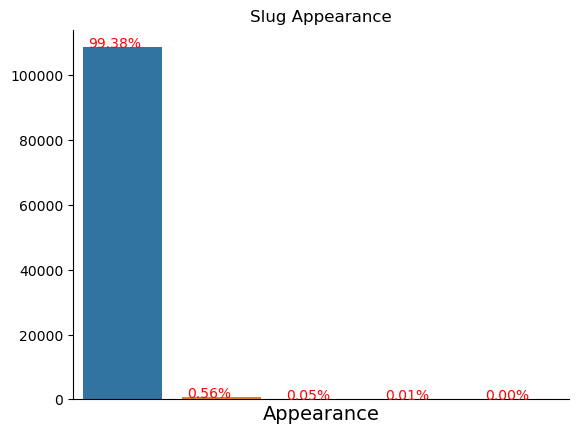

In [7]:
df = podcast.groupby("title")['slug'].count().value_counts()
plot = sns.barplot(x=df.index, y=df.values)

barplot_values_percent(plot)

plt.xlabel("Appearance", size = 14)
plt.xticks([])
plt.title("Slug Appearance")
sns.despine()
plt.show()





Slugs are overwhelmingly unique

# Categories

In [8]:
bot_free_df.head()

,podcast_id,title_x,author_id,created_at,rating,category,slug,title_y,year
4855,f232a34cc1cbc4665428eef07b3f1dbb,A mess of a podcast,2281329ADCB2345,2019-05-01 13:52:22-07:00,1,arts,the-comic-conspiracy,The Comic Conspiracy,2019
4858,f232a34cc1cbc4665428eef07b3f1dbb,Negative,8FE61D614BDC8F6,2016-06-01 04:48:06-07:00,1,arts,the-comic-conspiracy,The Comic Conspiracy,2016
4859,f232a34cc1cbc4665428eef07b3f1dbb,the best,EB842D63A615423,2016-07-01 20:55:00-07:00,5,arts,the-comic-conspiracy,The Comic Conspiracy,2016
4861,f232a34cc1cbc4665428eef07b3f1dbb,Great podcast!,4DD560A779AE4AC,2017-10-04 19:09:45-07:00,5,arts,the-comic-conspiracy,The Comic Conspiracy,2017
4862,f232a34cc1cbc4665428eef07b3f1dbb,Best Comic Podcast out there,BE4C3DB890FA8D9,2016-12-08 08:56:31-07:00,5,arts,the-comic-conspiracy,The Comic Conspiracy,2016


In [9]:
print(categories.shape, '\n')
print(categories.isna().sum())


categories.head()

(212372, 2) 

podcast_id    0
category      0
dtype: int64


,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts


In [10]:
categories.describe()

,podcast_id,category
count,212372,212372
unique,110024,17
top,fa8c359031380cd4f3b38358c8a75f92,society
freq,8,27594


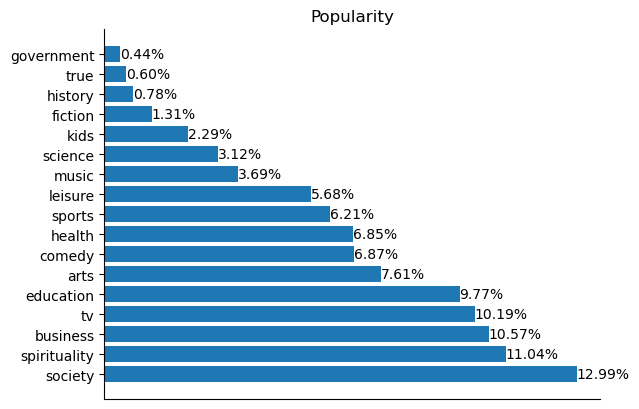

In [13]:
percent = (
    categories.groupby("category")
    .count()
    .sort_values(by="podcast_id", ascending=False)["podcast_id"]
    .values
    / categories.groupby("category")
    .count()
    .sort_values(by="podcast_id", ascending=False)["podcast_id"]
    .values.sum()
    * 100
)
new_labels = [
    i + "  {:.2f}%".format(j)
    for i, j in zip(
        categories.groupby("category")
        .count()
        .sort_values(by="podcast_id", ascending=False)["podcast_id"]
        .index,
        percent,
    )
]


df = (
    categories.groupby("category").count().sort_values(by="podcast_id", ascending=False)
)
fig, ax = plt.subplots()
bars = ax.barh(categories["category"].value_counts().index, percent)
ax.bar_label(bars, fmt="{:,.2f}%")


plt.xticks([])
plt.title("Popularity")
sns.despine()
plt.show()

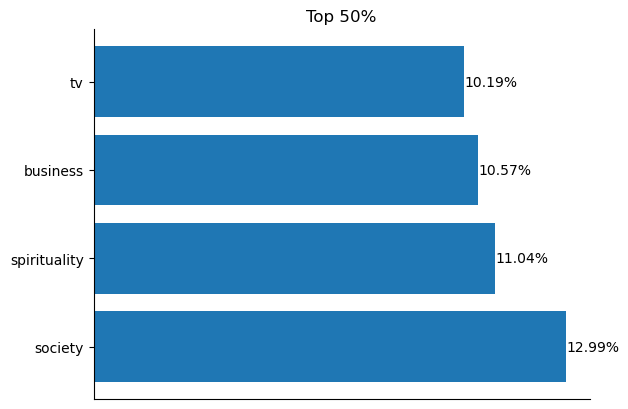

In [ ]:
percent = categories.groupby('category').count().sort_values(by='podcast_id', ascending=False)['podcast_id'].values/categories.groupby('category').count().sort_values(by='podcast_id', ascending=False)['podcast_id'].values.sum()*100


df = categories.groupby('category').count().sort_values(by='podcast_id', ascending=False)
fig, ax = plt.subplots()
bars = ax.barh(categories['category'].value_counts().head(4).index, percent[:(np.cumsum(percent)<=50).argmin()])
ax.bar_label(bars, fmt='{:,.2f}%')


plt.xticks([])
plt.title("Top 50%")
sns.despine()
plt.show()

Formulating The Null Hypothesis: <br>
H0- The difference in mean between 

# Testing, Testing, 1, 2, 3.

The Mann-Whitney U test has fewer assumptions, but it does have its own set of requirements:

Independent Samples:
The observations in one sample should be independent of the observations in the other sample. 

Ordinal Data:
The Mann-Whitney U test is suitable for ordinal or continuous data. It does not assume a specific distribution of the data, making it robust to deviations from normality.

Random Sampling:
The data should be collected through a random sampling process to ensure that the results can be generalized to the larger population.

Similar Shapes of Distributions:
While the Mann-Whitney U test is robust to differences in the shapes of the distributions, it is more powerful when the shapes of the distributions are similar.

Equal Variances:
The Mann-Whitney U test does not assume equal variances between the two groups. This makes it applicable when the assumption of homogeneity of variances for the t-test is violated.

In [ ]:
np.random.seed(42)
data1 = year_2020['rating'][:len(year_2019['rating'])].values
data2 = year_2019['rating'].values

np.random.shuffle(data1)
np.random.shuffle(data2)


sample_size = 2000  # Choose the desired sample size
data1 = np.random.choice(data1, size=sample_size, replace=False)
data2 = np.random.choice(data2, size=sample_size, replace=False)


In [ ]:
test_stat_var, p_value_var= stats.levene(data1,data2)
print("p value:%.4f" % p_value_var)
if p_value_var <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.0046
Reject null hypothesis >> The variances of the samples are different.


In [ ]:
stat, p = shapiro(data1)
print('stat={0:.3f}, p={0:.3f}' .format(stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.435, p=0.435
Probably not Gaussian


In [ ]:
stat, p = shapiro(data2)
print('stat={0:.3f}, p={0:.3f}' .format(stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.393, p=0.393
Probably not Gaussian


In [ ]:
from scipy.stats import anderson

result = anderson(data1)
print('stat={0:.3g}'.format(result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
        print('Probably not Gaussian at the %.1f%% level' % (sl))


stat=531
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


In [ ]:
from scipy.stats import anderson

result = anderson(data2)
print('stat={0:.3g}'.format(result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
        print('Probably not Gaussian at the %.1f%% level' % (sl))


stat=568
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


In [ ]:
from scipy.stats import pearsonr

stat, p = pearsonr(data1, data2)
print('stat={0:.3f}, p={0:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.010, p=0.010
Probably independent


Data Type:
data1: ordinal
data2: ordinal


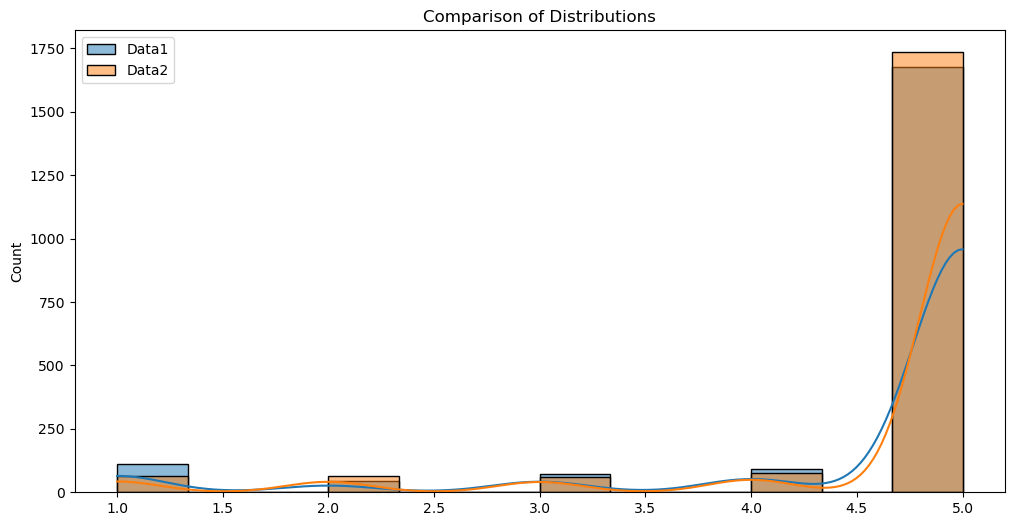

In [ ]:


print("Data Type:")
print("data1:", "ordinal" if np.issubdtype(data1.dtype, np.integer) else "continuous")
print("data2:", "ordinal" if np.issubdtype(data2.dtype, np.integer) else "continuous")

# 3. Random Sampling (no specific test, check documentation or source of data)
# ... ensure that data was collected through a random sampling process

# 4. Similar Shapes of Distributions (visual inspection)
plt.figure(figsize=(12, 6))
sns.histplot(data1, label='Data1', kde=True)
sns.histplot(data2, label='Data2', kde=True)
plt.legend()
plt.title('Comparison of Distributions')
plt.show()

Null Hypothesis:
here is no difference between the distributions of the two samples.

Alternative Hypothesis:
There is a difference between the distributions of the two samples.



In [ ]:
from scipy.stats import mannwhitneyu

# Assume 'group1' and 'group2' are your two independent groups
statistic, p_value = mannwhitneyu(data1, data2)

# Display results
print("Mann-Whitney U test statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.01:
    print("There is a statistically significant difference.")
else:
    print("There is no statistically significant difference.")

Mann-Whitney U test statistic: 1939623.5
P-value: 0.007252766832955017
There is a statistically significant difference.


The P-Value is smaller than Alpha. This suggests that there is evidence that the two samples come from populations with different distributions.

We therefore reject the Null Hypothesis 



However, failing to reject H₀ does not mean H₀ is valid, nor does it mean H₁ is wrong.

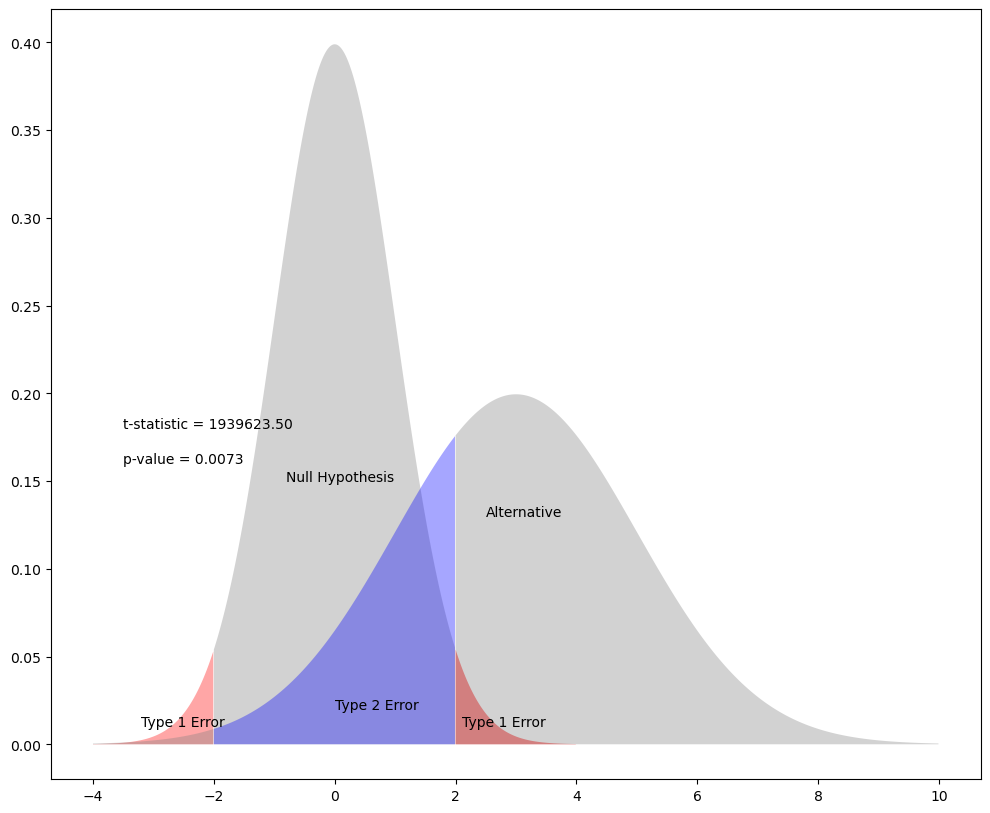

In [ ]:


# Set the significance level (alpha)
alpha = 0.05

# Plotting
plt.figure(figsize=(12, 10))

# Shading based on the p-value
if p_value < alpha / 2:
    plt.fill_between(x=np.arange(-4, -2, 0.01),
                     y1=stats.norm.pdf(np.arange(-4, -2, 0.01)),
                     facecolor='red', alpha=0.35)
    plt.fill_between(x=np.arange(2, 4, 0.01),
                     y1=stats.norm.pdf(np.arange(2, 4, 0.01)),
                     facecolor='red', alpha=0.5)
elif p_value < alpha:
    plt.fill_between(x=np.arange(2, 4, 0.01),
                     y1=stats.norm.pdf(np.arange(2, 4, 0.01)),
                     facecolor='red', alpha=0.5)

plt.fill_between(x=np.arange(-2, 2, 0.01),
                 y1=stats.norm.pdf(np.arange(-2, 2, 0.01)),
                 facecolor='grey', alpha=0.35)

plt.fill_between(x=np.arange(-4, -2, 0.01),
                 y1=stats.norm.pdf(np.arange(-4, -2, 0.01), loc=3, scale=2),
                 facecolor='grey', alpha=0.35)

plt.fill_between(x=np.arange(-2, 2, 0.01),
                 y1=stats.norm.pdf(np.arange(-2, 2, 0.01), loc=3, scale=2),
                 facecolor='blue', alpha=0.35)

plt.fill_between(x=np.arange(2, 10, 0.01),
                 y1=stats.norm.pdf(np.arange(2, 10, 0.01), loc=3, scale=2),
                 facecolor='grey', alpha=0.35)

# Text annotations
plt.text(x=-3.5, y=0.18, s=f"t-statistic = {statistic:.2f}", color='black')
plt.text(x=-3.5, y=0.16, s=f"p-value = {p_value:.4f}", color='black')

plt.text(x=-0.8, y=0.15, s="Null Hypothesis")
plt.text(x=2.5, y=0.13, s="Alternative")
plt.text(x=2.1, y=0.01, s="Type 1 Error")
plt.text(x=-3.2, y=0.01, s="Type 1 Error")
plt.text(x=0, y=0.02, s="Type 2 Error")

plt.show()

In [ ]:
lower_quantile = stats.norm.ppf(0.025)  # Lower cutoff value
upper_quantile = stats.norm.ppf(0.975)  # Upper cutoff value

# Area under alternative, to the left the lower cutoff value
low = stats.norm.cdf(lower_quantile,    
                     loc=3,             
                     scale=2)

# Area under alternative, to the left the upper cutoff value
high = stats.norm.cdf(upper_quantile, 
                      loc=3, 
                      scale=2)          

# Area under the alternative, between the cutoffs (Type II error)
high-low

0.294956061112323

we'd fail to reject the null hypothesis about 30% of the time because the distributions are close enough together that they have significant overlap.

# Reviews

In [ ]:
reviews.head()

,podcast_id,title,author_id,created_at,rating
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,F7E5A318989779D,2018-04-24 12:05:16-07:00,5
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,F6BF5472689BD12,2018-05-09 18:14:32-07:00,5
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,1AB95B8E6E1309E,2019-06-11 14:53:39-07:00,1
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,11BB760AA5DEBD1,2018-05-31 13:08:09-07:00,5
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,D86032C8E57D15A,2019-06-19 13:56:05-07:00,5


In [ ]:
reviews.describe()

,rating
count,2.067527e+06
mean,4.627081e+00
std,1.045882e+00
min,1.000000e+00
25%,5.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [ ]:

users = reviews['author_id'].nunique()/reviews.shape[0]*100
print(reviews['author_id'].nunique())
print(f'Unique reviewers = {users :.0f}%')

1475283
Unique reviewers = 71%


In [ ]:
reviews.groupby('podcast_id').count().sort_values('rating',ascending=False)

,title,author_id,created_at,rating
podcast_id,,,,
bf5bf76d5b6ffbf9a31bba4480383b7f,33104,33104,33104,33104
bc5ddad3898e0973eb541577d1df8004,10675,10675,10675,10675
bad6c91efdbee814db985c7a65199604,9698,9698,9698,9698
f5fce0325ac6a4bf5e191d6608b95797,8248,8248,8248,8248
f2377a9b0d9a2e0fb05c3dad55759328,7389,7389,7389,7389
...,...,...,...,...
cfe982d2c85b788a52ef60ebacb472e6,1,1,1,1
cfea11ed2b2f92cf3f4c95bfea219ed4,1,1,1,1
cfeaacbecd8b90c3895a4e07b9517b1b,1,1,1,1


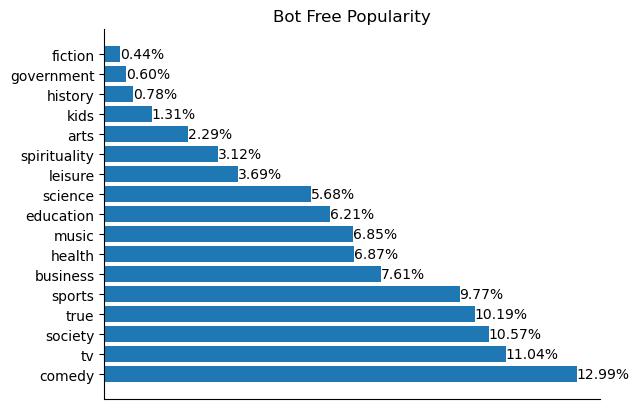

In [ ]:
percent = (
    categories.groupby("category")
    .count()
    .sort_values(by="podcast_id", ascending=False)["podcast_id"]
    .values
    / categories.groupby("category")
    .count()
    .sort_values(by="podcast_id", ascending=False)["podcast_id"]
    .values.sum()
    * 100
)
new_labels = [
    i + "  {:.2f}%".format(j)
    for i, j in zip(
        categories.groupby("category")
        .count()
        .sort_values(by="podcast_id", ascending=False)["podcast_id"]
        .index,
        percent,
    )
]


df = (
    bot_free_df.groupby("category").count().sort_values(by="podcast_id", ascending=False)
)
fig, ax = plt.subplots()
bars = ax.barh(bot_free_df["category"].value_counts().index, percent)
ax.bar_label(bars, fmt="{:,.2f}%")


plt.xticks([])
plt.title("Bot Free Popularity")
sns.despine()
plt.show()

# Users

In [ ]:

all_df[all_df['author_id'].map(all_df['author_id'].value_counts()) > 100]

,podcast_id,title_x,author_id,created_at,rating,category,slug,title_y
770,ad4f2bf69c72b8db75978423c25f379e,Sell crazy somewhere else,B3BCE599817B315,2020-10-01T23:23:38-07:00,1,arts,ted-talks-daily,TED Talks Daily
771,ad4f2bf69c72b8db75978423c25f379e,Sell crazy somewhere else,B3BCE599817B315,2020-10-01T23:23:38-07:00,1,arts-design,ted-talks-daily,TED Talks Daily
772,ad4f2bf69c72b8db75978423c25f379e,Sell crazy somewhere else,B3BCE599817B315,2020-10-01T23:23:38-07:00,1,education,ted-talks-daily,TED Talks Daily
773,ad4f2bf69c72b8db75978423c25f379e,Sell crazy somewhere else,B3BCE599817B315,2020-10-01T23:23:38-07:00,1,society-culture,ted-talks-daily,TED Talks Daily
774,ad4f2bf69c72b8db75978423c25f379e,Fabulous,C9EDC715E2AEA2F,2020-09-30T15:50:06-07:00,5,arts,ted-talks-daily,TED Talks Daily
...,...,...,...,...,...,...,...,...
4527093,cb88344551a5835d810a01553ceb11ef,Goodbye negative thoughts,3D15633988F6C0A,2021-10-01T05:34:11-07:00,5,christianity,the-christian-mindset-coach-with-alicia-michelle,The Christian Mindset Coach with Alicia Michelle
4527926,daa9d3c604289be5710564a207074f7d,Awesome!,01B41DDC59E7F7F,2022-06-23T09:46:07-07:00,5,education-self-improvement,the-working-mom-happiness-method,The Working Mom Happiness Method
4528070,af2c964e3af79e8aae5892cbaf165d34,Refreshing vulnerability and honesty!,24095662D53F51F,2023-01-09T11:59:39-07:00,5,health-fitness-sexuality,ask-a-sex-therapist-with-heather-shannon,Ask A Sex Therapist with Heather Shannon
4529454,a054664eb47df3cbfa51568d3660d130,Amazing Pod!,8EA31F030185A88,2021-12-28T14:52:52-07:00,5,news-tech-news,the-metaverse-guy,The Metaverse Guy


In [ ]:
all_df.groupby('author_id').count().sort_values('podcast_id', ascending=False).head()

,podcast_id,title_x,created_at,rating,category,slug,title_y
author_id,,,,,,,
D3307ADEFFA285C,1654,1654,1654,1654,1654,1654,1654
791F376ACA3C08D,1264,1264,1264,1264,1264,1264,1264
96A3F0358E7808D,1187,1187,1187,1187,1187,1187,1187
04C3B6DEFE22FB1,865,865,865,865,865,865,865
184F09732A68A08,853,853,853,853,853,853,853


In [ ]:
all_df[all_df['author_id'] == '638AB2A1FAD6645'].value_counts().to_frame().sort_index().reset_index()

,podcast_id,title_x,author_id,created_at,rating,category,slug,title_y,0
0,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:27-07:00,5,sports,raider-power-podcast,Raider Power Podcast,1
1,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:27-07:00,5,sports-basketball,raider-power-podcast,Raider Power Podcast,1
2,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:27-07:00,5,sports-football,raider-power-podcast,Raider Power Podcast,1
3,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:33-07:00,5,sports,raider-power-podcast,Raider Power Podcast,2
4,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:33-07:00,5,sports-basketball,raider-power-podcast,Raider Power Podcast,2
5,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:33-07:00,5,sports-football,raider-power-podcast,Raider Power Podcast,2
6,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:36-07:00,5,sports,raider-power-podcast,Raider Power Podcast,4
7,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:36-07:00,5,sports-basketball,raider-power-podcast,Raider Power Podcast,4
8,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:36-07:00,5,sports-football,raider-power-podcast,Raider Power Podcast,4
9,cb32c9f3c108d06349a72f2ad56fc3f4,Finally a Texas Tech Red Raider Podcast!,638AB2A1FAD6645,2018-09-11T19:12:37-07:00,5,sports,raider-power-podcast,Raider Power Podcast,6


So many bots!

# Sources

https://napsterinblue.github.io/notes/python/viz/subplots/

https://www.kaggle.com/code/kanncaa1/statistical-learning-tutorial-for-beginners



https://stackoverflow.com/questions/30228069/how-to-display-the-value-on-horizontal-bars

https://www.kaggle.com/code/shashwatwork/guide-to-statistical-hypothesis-tests-in-python
https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e


https://www.kaggle.com/code/ahmedshahriarsakib/churn-prediction-i-eda-statistical-analysis